# GD4. 한영 번역기 만들기 project

## Step 1. 데이터 다운로드

In [1]:
import tensorflow as tf
import numpy as np
import gzip # tar.gz파일 열기

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.4.1


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

print("완료!")

완료!


In [3]:
train_ko_path = os.getenv('HOME') + '/aiffel/NLPGD/GD4/korean-english-park.train.ko'
train_en_path = os.getenv('HOME') + '/aiffel/NLPGD/GD4/korean-english-park.train.en'
test_ko_path = os.getenv('HOME') + '/aiffel/NLPGD/GD4/korean-english-park.test.ko'
test_en_path = os.getenv('HOME') + '/aiffel/NLPGD/GD4/korean-english-park.test.en'

In [4]:
with open(train_ko_path, "r") as f:
    raw_train_ko = f.read().splitlines()
    
with open(train_en_path, "r") as f:
    raw_train_en = f.read().splitlines()

In [5]:
for i in range(0,100,20):
    print(">>", raw_train_ko[i])
    print(">>", raw_train_en[i],'\n')

>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> Much of personal computing is about "can you top this?" 

>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations. 

>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said. 

>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project. 

>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they g

In [6]:
print(len(raw_train_ko))
print(len(raw_train_en))

94123
94123


## Step2. 데이터 정제
set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의  
중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [7]:
cleaned_corpus = list(set(zip(raw_train_ko, raw_train_en)))
print(cleaned_corpus[0:5], '\n')
print(len(cleaned_corpus))

[('비평가들은 이 참사가 한국의 비상대응 체제에 대한 많은 문제와 테러에 대한 잠재적 취약성을 노출시켰다고 말했다.', "Critics said the tragedy revealed problems with the nation's emergency response system and a potential vulnerability to terrorism."), ('그는 “제품 마진 많은 제품일수록 가격 흥정을 많이 한다”고 말했다.', '"Any product with a large product margin is ripe for haggling," he said.'), ('숀 맥코맥 미 국무부 대변인은 기자회견을 통해 “여러 경로를 통해 국제사회의 관심을 이끌어낼 것”이라며 “미안먀 군부에 압력을 가하기 위해서는 모든 사람들의 노력이 필요하다”고 강조했다.', 'State Department spokesman Sean McCormack told a news conference the United States would work on "many, many different fronts" to keep Myanmar on the international agenda. "It requires everybody\'s effort and it requires concerted pressure from all parties involved," he said.'), ('쟁점이 되고 있는 랄 마스지드(붉은 사원) 외부에서 수 시간 동안의 총격전이 있은 후, 휴전을 위한 협의가 있었다.', 'After several hours of shooting outside the controversial Lal Masjid (Red Mosque) a ceasefire was negotiated.'), ('신화통신은 장 팅 수문기상학 사무국장의 말을 인용 “방수로의 확보는 제방안전을 위해 꼭 필요한 작업”이라고 전했다.', '¡°Increasing the outflow of water 

In [8]:
# 한글 형태소 분리를 위해 konlpy 불러오기
from konlpy.tag import Mecab

In [9]:
def preprocess_sentence_ko(sentence):
#     sentence = sentence.lower.strip() ## 이거 문제될 수 있음 ##
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+' ," ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ-가-힣?.!,]+"," ",sentence)
    
    sentence = sentence.strip()
    
    tokenizer = Mecab()
    sentence =  tokenizer.morphs(sentence)
        
    return sentence

In [10]:
def preprocess_sentence_en(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+' ," ", sentence)
    sentence = re.sub(r"[^a-zA-Zㅏ-ㅣ-가-힣-ㄱ-ㅎ?,!.]+"," ", sentence)
    
    sentence = sentence.strip()
    
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = sentence.split()
    
    return sentence

In [11]:
enc_corpus = []
dec_corpus = []

for i in cleaned_corpus:
    ko = preprocess_sentence_ko(i[0])
    en = preprocess_sentence_en(i[1], s_token=True, e_token=True)
    
    if len(ko) <= 40 and len(en) <=40:
        enc_corpus.append(ko)
        dec_corpus.append(en)

In [12]:
for i in range(6):
    print(">>", enc_corpus[i])
    print(">>", dec_corpus[i], '\n')

>> ['비평가', '들', '은', '이', '참사', '가', '한국', '의', '비상', '대응', '체제', '에', '대한', '많', '은', '문제', '와', '테러', '에', '대한', '잠재', '적', '취약', '성', '을', '노출', '시켰', '다고', '말', '했', '다', '.']
>> ['<start>', 'critics', 'said', 'the', 'tragedy', 'revealed', 'problems', 'with', 'the', 'nation', 's', 'emergency', 'response', 'system', 'and', 'a', 'potential', 'vulnerability', 'to', 'terrorism', '.', '<end>'] 

>> ['그', '는', '제품', '마진', '많', '은', '제품', '일수록', '가격', '흥정', '을', '많이', '한다', '고', '말', '했', '다', '.']
>> ['<start>', 'any', 'product', 'with', 'a', 'large', 'product', 'margin', 'is', 'ripe', 'for', 'haggling', ',', 'he', 'said', '.', '<end>'] 

>> ['쟁점', '이', '되', '고', '있', '는', '랄', '마스지드', '붉', '은', '사원', '외부', '에서', '수', '시간', '동안', '의', '총격전', '이', '있', '은', '후', ',', '휴전', '을', '위한', '협의', '가', '있', '었', '다', '.']
>> ['<start>', 'after', 'several', 'hours', 'of', 'shooting', 'outside', 'the', 'controversial', 'lal', 'masjid', 'red', 'mosque', 'a', 'ceasefire', 'was', 'negotiated', '.', '<

### Step3. 데이터 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요.  
단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다.  
(난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.)

In [13]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=15000, oov_token='<unk>')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [14]:
len_of_ko = [len(v) for v in enc_corpus]
max_len_ko = max(len_of_ko)
temp_ko = 0
for v in len_of_ko:
    temp_ko += v

print("한국어 최대 token 길이:", max_len_ko)
print("한국어 평균 token 길이:", temp_ko/len(len_of_ko))
print("한국어 최소 token 길이:", min(len_of_ko))

한국어 최대 token 길이: 40
한국어 평균 token 길이: 24.559605332147
한국어 최소 token 길이: 0


In [15]:
len_of_en = [len(v) for v in dec_corpus]
max_len_en = max(len_of_en)
temp_en = 0
for v in len_of_en:
    temp_en += v

print("영어 최대 token 길이:", max_len_en)
print("영어 평균 token 길이:", temp_en/len(len_of_en))
print("영어 최소 token 길이:", min(len_of_en))

영어 최대 token 길이: 40
영어 평균 token 길이: 23.109407521568503
영어 최소 token 길이: 2


In [84]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

In [85]:
## [_Derived_]RecvAsync is cancelled.##
# long-running operation Error 해결하기 위해서 데이터셋의 크기를 줄여봅니다.
enc_tensor = enc_tensor[:30000][:]
dec_tensor = dec_tensor[:30000][:]

print(enc_tensor.shape, dec_tensor.shape)

(30000, 40) (30000, 40)


In [86]:
print(enc_tensor.shape, dec_tensor.shape)

(30000, 40) (30000, 40)


In [87]:
print(enc_tensor[0], '\n')
print(dec_tensor[0])

[5000   16    8    4 5167   14  113    7 1458 1321 1630    9   63  123
    8  121   29  107    9   63 3321   33 5943  116    6 1876  494   23
   31   10    3    2    0    0    0    0    0    0    0    0] 

[   4 1763   13    2 3810 2239  671   19    2  291   12  423 1133  398
   11    9 1242    1    7 1192    3    5    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


### Step 4. 모델 설계

한국어를 영어로 잘 번역해 줄 Attention 기반 Seq2seq 모델을 설계하세요.  
모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다.

In [88]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
        
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]
        
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [89]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [90]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        
        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)
        
        return out, h_dec, attn

In [95]:
BATCH_SIZE = 4
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 1024  ## 원래 1024였음 ##
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                    sample_state, sample_output)

print('Decoder Output:', sample_logits.shape)
print('Decoder Hidden State:', h_dec.shape)
print('Attention:', attn.shape)

Encoder Output: (4, 30, 1024)
Decoder Output: (4, 42976)
Decoder Hidden State: (4, 1024)
Attention: (4, 30, 1)


### Optimizer & Loss
Encoder-Decoder 구조의 경우 입출력이 단순하지 않아 학습 과정을 직접 정의해줘야 합니다.

In [96]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss += mask
    
    return tf.reduce_mean(loss)

Optimizer는 모델이 학습할 때에 정답을 찾아가는 방법 정도로 설명할 수 있는데, 일반적으로 Adam을 사용합니다.

여기서 fit() 함수를 사용할 수 없는 이유는 바로 Loss 함수 때문입니다. 앞서 설명한 것처럼 Encoder-Decoder 구조는 학습 과정이 일반적이지 않으므로 직접 Loss를 커스텀해서 사용해야 하기 때문이죠.

SparseCategoricalCrossentropy() 함수는 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구해줍니다. CategoricalCrossentropy()라면 [ 0.1, 0.2, 0.7 ] 과 One-hot 인코딩된 라벨 [0, 0, 1] 을 비교하여 점수를 채점하겠지만, SparseCategoricalCrossentropy() 함수라면 [ 0.1, 0.2, 0.7 ] 과 정수 인덱스 답안 2 를 비교하여 점수를 채점하는 거죠. from_logits 는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정합니다. True 로 줬으니 모델의 출력값을 그대로 전달하면 됩니다.  
  
 pad_sequences()는 가장 긴 문장을 기준으로 패딩을 적용합니다. 만약 모델에게 \<PAD> 토큰이 패딩을 위한 토큰이라고 명시하지 않으면 모델은 데이터의 굉장히 많은 부분이 \<PAD> 로 이뤄져 있다고 생각하게 됩니다. 쉽게 말해 유난히 같은 답이 많은 객관식 시험이라고나 할까요...? 어떤 시험이 한 번호로만 찍어도 80점 이상을 받을 수 있다면 그 시험은 공부를 절대 하지 않겠죠! 모델은 심지어 10,000개의 정답이 넘게 있는 고난도의 문제를 풀고 있기 때문에 패딩에 대한 처리를 해주지 않으면 \<PAD> 토큰만을 생성할 확률이 굉장히 높아집니다.  
  
이것은 종종 발생하는 문제입니다.  이 문제를 방지하기 위해 mask 가 사용됩니다! mask 는 정답지에서 \<PAD> 토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할을 해주죠. equal() 함수에 정확히는 0 이 아닌 \<PAD> 토큰의 인덱스를 전달하는 것이 맞지만 대부분의 경우는 0으로 패딩되기 때문에 편의상 0을 전달하여 처리하도록 하겠습니다.

### train_step 구현하기

In [97]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_out = encoder(src) # context vector 생성
        h_dec = enc_out[:, -1] # t=0일 때 Decoder의 Hidden State는 Encoder의 Final State로 정의
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1) # Decoder에 입력으로 전달할 <start>토큰 문장 생성
        
        for t in range(1, tgt.shape[1]): # 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            
            loss += loss_function(tgt[:, t], pred) # 예측된 단어와 정답 간의 loss를  구함
            dec_src = tf.expand_dims(tgt[:, t], 1) # t=1의 정답 단어를 다음 입력으로 사용
            
    batch_loss = (loss / int(tgt.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

train_step()의 학습 과정은 아래와 같습니다.  
1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성  
2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]  
3. Decoder에 입력으로 전달할 \<start> 토큰 문장 생성  
4. <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred  
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)  
6. 반복

## 훈련하기

In [101]:
from tqdm import tqdm
import random

EPOCHS = 1

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE)) # 각 배치의 시작 인덱스를 idx_list 배열에 저장
    random.shuffle(idx_list) # 학습이 원활하게 이루어질 수 있도록 인덱스를 섞음
    t = tqdm(idx_list)
    
    # 각 미니배치를 train_step() 함수에서 학습합니다. train_step()은 학습에 필요한 것은 모두 가져가 Loss를 계산한 후 반환하는 함수입니다.
    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx: idx+BATCH_SIZE],
                                dec_tensor[idx: idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1)) # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1))) # tqdm

Epoch  1: 100%|██████████| 7500/7500 [1:43:17<00:00,  1.21it/s, Loss 4.2890]


tqdm은 훈련의 진행 과정을 한눈에 볼 수 있게 해주는 라이브러리입니다.
먼저 EPOCHS = 10 만큼 반복하는 루프에 진입한 후, 각 배치의 시작 인덱스를 idx_list 배열에 저장합니다. 그리고 모델이 학습을 원활하게 할 수 있도록 데이터를 섞어줘야 하는데요, 인덱스를 섞어서 처리할 겁니다. 순차적인 인덱스로 데이터를 불러오는 게 아닌 랜덤한 인덱스로 데이터를 불러오는 것은 데이터를 섞는 것과 동일한 효과를 가져옵니다.
그 후에 각 미니배치를 train_step() 함수에서 학습합니다. train_step()은 학습에 필요한 것은 모두 가져가 Loss를 계산한 후 반환하는 함수입니다.

In [126]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence_ko(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [127]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [133]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

Input: ['커피', '마시', '러', '갈래요', '?']
Predicted translation: the not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


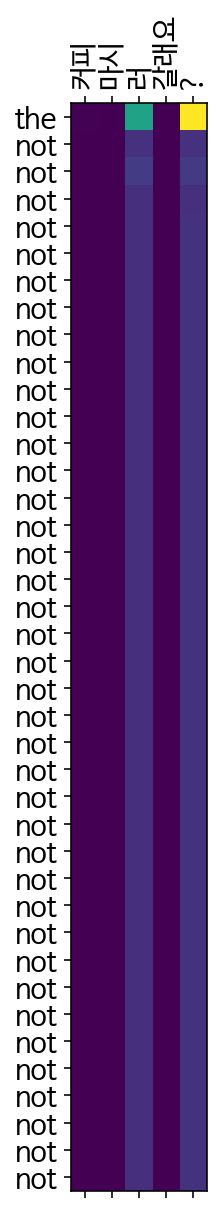

In [134]:
translate("커피 마시러 갈래요?", encoder, decoder)

Input: ['너무', '추워', '요', '.']
Predicted translation: not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


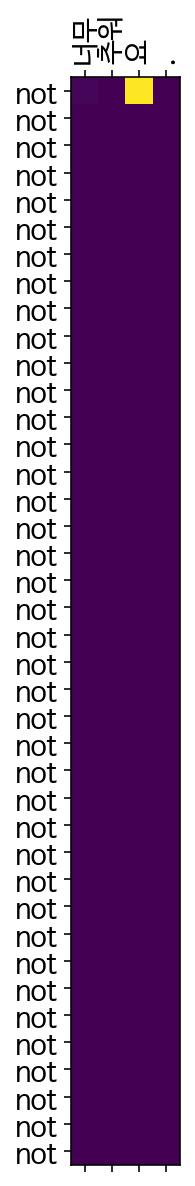

In [136]:
translate("너무 추워요.", encoder, decoder)

Input: ['심심', '한데', '뭐', '하', '고', '놀', '지', '?']
Predicted translation: the <unk> <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


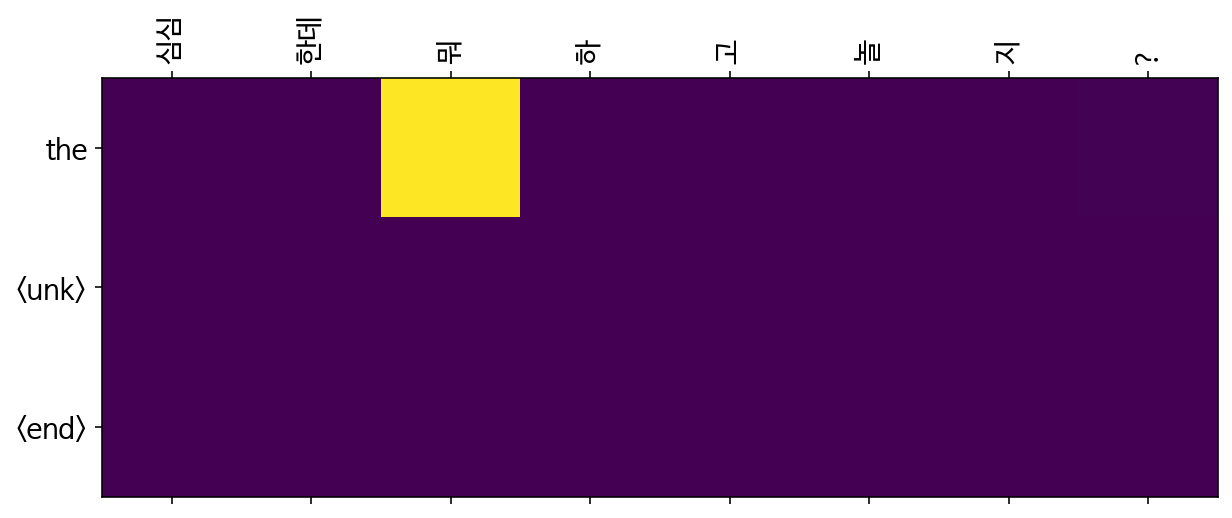

In [139]:
translate("심심한데 뭐 하고 놀지?", encoder, decoder)

## 회고
* 모델의 사이즈가 너무 커서 OOM 문제가 지속적으로 발생했다. 따라서 incode, decode tensor의 크기를 줄였다.  
* 배치 사이즈를 줄였기 때문에 학습에 너무 많은 시간이 소요되는 것 같다. epoch를 늘리면 결과가 제대로 나올지 궁금하다.